In [3]:
import json
import seaborn as sns
import os
import transformers
from tqdm.notebook import tqdm
import numpy as np
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir="mycache")
MAX_INPUT_TOKENS = 2048
MAX_INPUT_WORDS = 1500

In [4]:
files = [os.path.join('data', el) for el in os.listdir('data')]

descriptions = []
actions = []
actions_texts = []
descriptions_texts = []

for el in tqdm(files):
    j = json.load(open(el))
    for key, state in j.items():
        curr_actions = state['query_texts']
        text = state['main_text']
        descriptions.append(len(tokenizer.encode(text)))
        descriptions_texts.append((text, len(tokenizer.encode(text)), el))
        for action in curr_actions:
            actions.append(len(tokenizer.encode(action)))
            actions_texts.append((action, len(tokenizer.encode(action)), el))

  0%|          | 0/870 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2104 > 2048). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

### Tricky actions:
- I will cast a minor spell which allows the air to carry the sound to my ear. [You can do that even without being specialized in Air.]
- "Let’s arrange a marriage of our children. How about one of your kids gets to marry one of mine?" (unofficial, informal, and politically inconsequential understanding usually ignored outside of the enjoined kingdoms)
- "Let’s swear to a military alliance between us two." (peace agreement + provide troops and other military aid to the other as needed, an internationally recognized edict which tends to increase war and violent conflict)
- Fire your ballistae at and destroy Minâ€™s own ballistae installations; once his ballistae are eliminated, advance your cloud ladders, carrying a mix of infantry and archers, to storm the walls and capture the keep
- NOOOOOOOOO! I DIED! CURSE YOU SENTINELPENGUIN!!!
- Needles wonâ€™t puncture his skin, so he squirts it out his eye ducts
- The Epirus-Rome War (280-279BC) - MEDIUM DIFFICULTY
- 2: The Athens-Sparta War (432-418BC) - HARD DIFFICULTY
- Don’t care, you need to drink – get some of the water from under the pier
- “It’s OK, I’m just passing through,” you reply truthfully
- 4th British defenders
- Evidence: Attorneys Badge
- , Ko e fasi 'o e tu'i 'o e 'Otu Tonga
- Dossier: Double Trouble
- List of Noted Sailors of the Three Kingdoms
- MAIN MENU
- Synopsis mode. (Was there something you wanted to know? Click here!) *Spoiler Alert!*
- HARD: You are an eighteen year old, up-and-coming female model in India. A company called Pond's has asked you if you'd like to do a commerical with them. You are at their office, waiting to discuss the potential contract. data/are-you-happy-with-your-choices~3f.json
- (Intelligence) Rhode is a hypocrite. She might brag about her years in the arena, but she’s never surrendered to an honourable death. I point out as much, no matter what punishment it might get me. data/The-Price-of-Freedom~3a-Innocence-Lost.json
- "So, that's Pegasi Station - an impressive piece of technology," the captain said. "Lieutenant Gregari, other than humans, which species inhabit this station?" (Turn to Section - 54)
-  Zorek isn’t interested in the bureaucracy. He will go and find someone in charge
- If you think it's best to stay put and wait for Andrade's return, turn to page 115. data/Marooned-on-Giri-Minor.json
- Accept the King of Merrywed's marriage proposal in exchange for protection: go to section 8a if you sent soldiers with the messengers data/Survive-or-Conquer.json

In [ ]:
banned = ["are-you-happy-with-your-choices~3f.json", "Warlords~3a-Strategic-Conquest.json", 
          "Survive-or-Conquer.json", "Maintenance-Systems.json", "Algebra-Game.json",
          "Tower-of-Doom.json", "Practice-Simple-Italian.json"]
phrase_ban = ["Synopsis", "MENU", "HARD", "EASY", "MEDIUM", "Turn to Section", "go to section", 
              "turn to page", "go to page", "					", "Start over", "END THE GAME", "Rating:",
             "Rank:"]

for text, l, src in actions_texts:
    is_banned = False
    for ban in banned:
        if ban in src:
            is_banned = True
    for phrase in phrase_ban:
        if phrase in text:
            is_banned = True
    if is_banned:
        continue
    if l < 20:
        continue
    print(l, len(text), text, src)

### Tricky descriptions:
- 

In [ ]:
banned = ["are-you-happy-with-your-choices~3f.json", "Warlords~3a-Strategic-Conquest.json", 
          "Survive-or-Conquer.json", "Maintenance-Systems.json", "Sixteen-Words.json", 
          "How-well-do-you-know-your-British~2dEnglish~3f.json", "Harry-Potter-and-the-Deathly-Hallows-Quiz.json",
         "Monster-Trivia.json", "Z~2dDAY-Survival-Quiz.json", "Battlefield-Commander~3a-Ancient-Warfare.json", 
         "Algebra-Game.json", "Tower-of-Doom.json", "Practice-Simple-Italian.json", "ENG4U1-Seminar-Game.json",
         "Eating-Disorders-Midterm.json"]
# todo ban any quiz
phrase_ban = ["Synopsis", "MENU", "HARD", "EASY", "MEDIUM", "Turn to Section", "go to section", 
              "turn to page", "go to page", "					", "Start over", "END THE GAME", "Rating:",
             "Rank:", "THE END", "The end", "The End", "Please play again", "YOUR HEALTH", 
              "Your score was", "Your score is"]
from time import sleep

for text, l, src in descriptions_texts:
    if "quiz" in src.lower():
        continue
    is_banned = False
    for ban in banned:
        if ban in src:
            is_banned = True
    has_phrase = False
    for phrase in phrase_ban:
        if phrase in text:
            has_phrase = True
    if is_banned:
        continue
    if has_phrase:
        continue
    if l < 400:
        continue
    print(l, len(text), text, src)
    sleep(1)

In [40]:
import re
import random
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")


def fix_spaces(s):
    return _RE_COMBINE_WHITESPACE.sub(" ", s).strip()

def normalize_text(s):
    s = s.strip()
    s = fix_spaces(s)
    s = s.replace('”', '"')
    s = s.replace('“', '"')
    s = s.replace('‘', "'")
    s = s.replace('’', "'")
    s = s.replace('—', '-')
    s = s.replace('–', '-')
    s = s.replace('…', '...')
    s = s.replace('„', '"')
    return s

def is_non_english(s):
    return any(ord(el) > 256 and el not in {'‘', '’'} for el in s)

class DatasetCleaner:
    def __init__(self, max_text_tokens=400, banned=None, banned_phrases=None):
        self.max_text_tokens = max_text_tokens
        if banned is None:
            self.banned = ["are-you-happy-with-your-choices~3f.json", "Warlords~3a-Strategic-Conquest.json", 
                        "Survive-or-Conquer.json", "Maintenance-Systems.json", "Sixteen-Words.json", 
                        "How-well-do-you-know-your-British~2dEnglish~3f.json",
                        "Harry-Potter-and-the-Deathly-Hallows-Quiz.json",
                        "Monster-Trivia.json", "Z~2dDAY-Survival-Quiz.json", 
                        "Battlefield-Commander~3a-Ancient-Warfare.json", 
                        "Algebra-Game.json", "Tower-of-Doom.json", "Practice-Simple-Italian.json", 
                        "ENG4U1-Seminar-Game.json", "Eating-Disorders-Midterm.json",
                          "Strategy-Simulator.json", "You~21.json", "WWII-Grand-Strategy.json", "Attack: 10|100|00|00"]
        else:
            self.banned = banned
        
        if banned_phrases is None:
            self.banned_phrases = ["Synopsis", "MENU", "HARD", "EASY", "MEDIUM", "Turn to Section", "go to section", 
              "turn to page", "go to page", "			", "Start over", "END THE GAME", "Rating:",
             "Rank:", "THE END", "The end", "The End", "Please play again", "YOUR HEALTH", 
              "Your score was", "Your score is"] 
        else:
            self.banned_phrases = banned_phrases       
    
    def process(self, input_dir, output_dir):
        files = [el for el in os.listdir(input_dir)]
        written = 0
        for el in tqdm(files):
            if any(ban in el for ban in self.banned):
                continue
            j = json.load(open(os.path.join(input_dir, el)))
            allowed_nodes = dict()      
            bad_nodes = 0
            bad_actions = 0
            total_actions = 0
            for key, state in j.items():
                curr_actions = [normalize_text(t) for t in state['query_texts']]
                text = normalize_text(state['main_text'])
                if any(ban in el for ban in self.banned_phrases) or \
                   len(tokenizer.encode(text)) > self.max_text_tokens:
                    bad_nodes += 1
                    continue
                if is_non_english(text):
                    bad_nodes += 1
                    continue
                total_actions += len(curr_actions)
                allowed_actions = []
                allowed_nums = []
                for action, state in zip(curr_actions, state["next_nums"]):
                    if any(ban in action for ban in self.banned_phrases):
                        bad_actions += 1
                    if is_non_english(action):
                        continue
                    if str(state) not in j:
                        continue
                    allowed_actions.append(action)
                    allowed_nums.append(str(state))
                
                node = {
                    "query_texts": allowed_actions,
                    "next_nums": allowed_nums,
                    "main_text": text,
                }
                allowed_nodes[str(key)] = node
            
            for t in allowed_nodes:
                allowed_actions = []
                allowed_nums = []
                for action, state in zip(allowed_nodes[t]['query_texts'], allowed_nodes[t]["next_nums"]):
                    if state not in allowed_nodes:
                        bad_actions += 1
                        continue
                    allowed_actions.append(action)
                    allowed_nums.append(state)
                allowed_nodes[t]['query_texts'] = allowed_actions
                allowed_nodes[t]['next_nums'] = allowed_nums
                
            if bad_nodes / len(j) >= 0.3:
                continue
            if bad_nodes / len(j) >= 0.2:
                print(f"File: {el} Nodes banned: {bad_nodes}/{len(j)} Actions banned: {bad_actions}/{total_actions}")
            with open(os.path.join(output_dir, el), "w") as file:
                json.dump(allowed_nodes, fp=file)
                written += 1
        print(written/len(files), written, len(files))

DatasetCleaner().process("data", "data_cleaned")

  0%|          | 0/870 [00:00<?, ?it/s]

File: Facts-About-the-Planet-and-the-Solar-System.json Nodes banned: 10/48 Actions banned: 12/77
File: A-Hero-is-Born,-Episode-2.json Nodes banned: 16/59 Actions banned: 15/58
File: CYBERMONKEY.json Nodes banned: 4/17 Actions banned: 3/16
File: Warped.json Nodes banned: 62/230 Actions banned: 95/266
File: Reanimation-2.json Nodes banned: 15/72 Actions banned: 14/220
File: Would-You-Survive-Daniel-Wilson's-Robopocalypse~3f.json Nodes banned: 5/23 Actions banned: 3/26
File: De-Milite-Inprudenti.json Nodes banned: 25/94 Actions banned: 21/137
File: The-Price-of-Freedom~3a-Innocence-Lost.json Nodes banned: 103/490 Actions banned: 126/871
File: Edithe-Zilonis.json Nodes banned: 16/73 Actions banned: 16/73
File: The-Witcher~3a-The-First-Wish.json Nodes banned: 24/83 Actions banned: 39/155
File: A-Hero-is-Born~2e~2e.json Nodes banned: 4/14 Actions banned: 3/14
File: Archangel.json Nodes banned: 8/33 Actions banned: 10/47
File: Failing-.json Nodes banned: 27/119 Actions banned: 25/135
File: Th

In [46]:
train_k = 8
val_k = 1
test_k = 1
total_k = train_k + val_k + test_k
train_dir = "data_train"
val_dir = "data_val"
test_dir = "data_test"
files = sorted(os.listdir("data_cleaned"))
random.seed(42)
for file in files:
    c = random.randint(1, total_k)
    if c <= train_k:
        os.system(f'cp "{os.path.join("data_cleaned", file)}" "{os.path.join(train_dir, file)}"')
    elif c <= train_k + val_k:
        os.system(f'cp "{os.path.join("data_cleaned", file)}" "{os.path.join(val_dir, file)}"')
    else:
        os.system(f'cp "{os.path.join("data_cleaned", file)}" "{os.path.join(test_dir, file)}"')
        

In [43]:
!mkdir data_test

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
!rm data_cleaned/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


left - thr

0.75 - 0.35

0.72 - 0.3

0.701 - 0.25

0.6517 - 0.2

0.605 - 0.15

<AxesSubplot: ylabel='Count'>

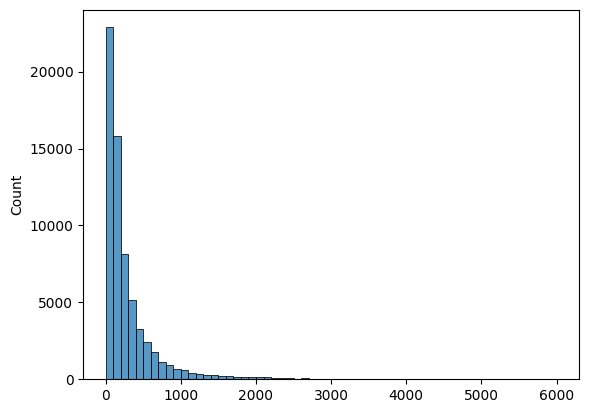

In [9]:
sns.histplot(x=np.array(descriptions), binwidth=100)